## Outline:

* Dataset Observation
* Exploratory Data Analysis and Cleaning
  * Missing Values
  * Univariate Analysis (Target)
  * Univariate Analysis (Independent Variables)
  * Multivariate Analysis
  * Outliers
  * Normalization
  * Correlation
* Model Preparation
  * Split training and testing
  * Encoding
* Models and Tuning / Evaluation Metrics
  * Regression Algorithms
  * RMSE / MSE / MAE

### Data Observation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv("bigdatamart_Train.csv")

In [3]:
print("Train Shape: ", df_train.shape)

Train Shape:  (8523, 12)


In [4]:
df_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
df_train.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [6]:
categorical_df = df_train.select_dtypes(include = 'object')
numerical_df = df_train.select_dtypes(exclude = 'object')

In [7]:
print(f"There are {len(categorical_df.columns)} Categorical Attributes")
print(f"There are {len(numerical_df.columns)} Numerical Attributes")

There are 7 Categorical Attributes
There are 5 Numerical Attributes


In [8]:
df_train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


## Exploratory Data Analysis

Exploratory data analysis is an approach to analyzing data sets to summarize their main characteristics, often using statistical graphics and other data visualization methods.

We will be improve our features as we go through the visulizations.

But first, let's analyze the missing values.

In [9]:
xdf = df_train.copy()

#### Missing Values

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

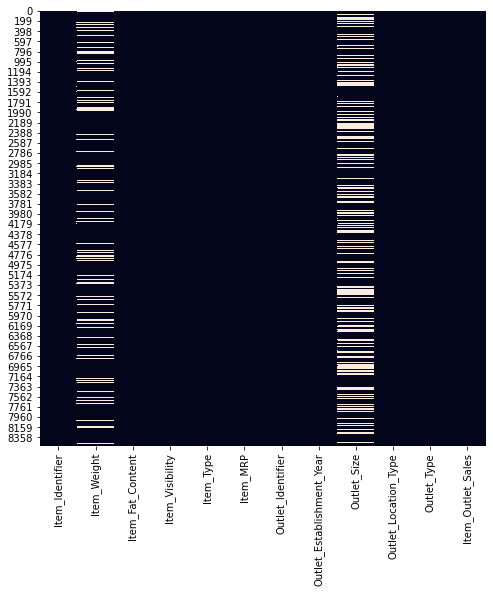

In [11]:
plt.figure(figsize = (8,8))
sns.heatmap(xdf.isnull(), cbar = False);

Now, we know Item_Weight and Outlet_Size contains huge number of "NaN" but how much?



In [12]:
## Let's list them out:

total = xdf.isnull().sum().sort_values(ascending = False)
percent = ((xdf.isnull().sum() / xdf.shape[0]) * 100).sort_values(ascending = False)
percent = np.round(percent, 3)
types = xdf[percent.index].dtypes

missing_data = pd.concat([total, percent, types], axis = 1, keys = ["Total","Percent","Type"])
missing_data.head(5)

,Total,Percent,Type
Outlet_Size,2410,28.276,object
Item_Weight,1463,17.165,float64
Item_Outlet_Sales,0,0.000,float64
Outlet_Type,0,0.000,object
Outlet_Location_Type,0,0.000,object


These are the values in % . 28.27% and 17.16 % values are missing in Outlet_Size and Item_Weight respectively.

#### Outlet_Size

Since this is a categorical attribute we will impute by using mode

In [13]:
xdf['Outlet_Size'].fillna(xdf['Outlet_Size'].mode()[0], inplace = True)

#### Item_Weight

It is a numeric variable, so we will be replacing it by median



In [14]:
xdf['Item_Weight'].fillna(xdf['Item_Weight'].median(), inplace = True)

##### Let's confirm the impute

In [15]:
xdf.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

### Univariate Analysis

Starting with the analyzation of *Target Attribute*

In [16]:
xdf['Item_Outlet_Sales'].describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

#### Let's check the distribution of the Target Attribute

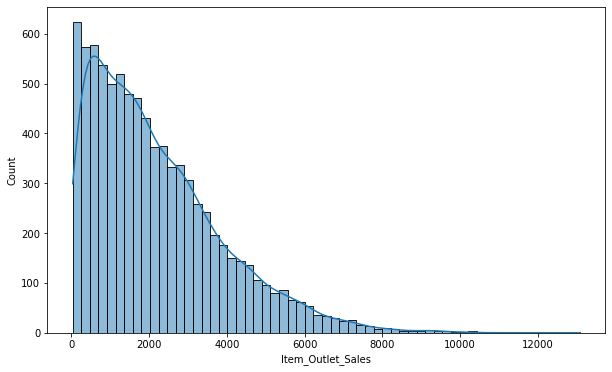

In [17]:
plt.figure(figsize = (10,6))
sns.histplot(data = xdf, x = 'Item_Outlet_Sales', kde = True);

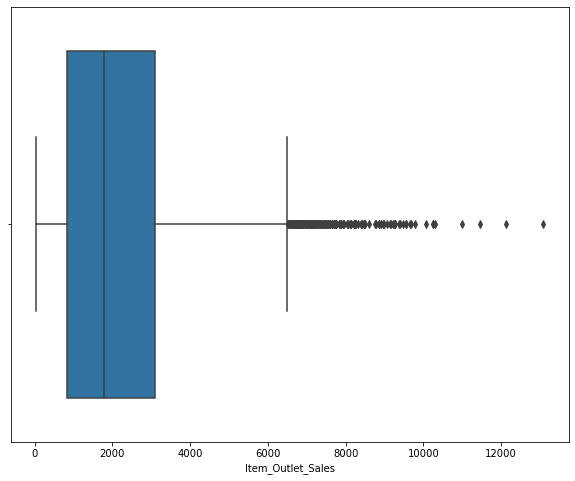

In [18]:
## let's confirm the outliers

plt.figure(figsize = (10,8))
sns.boxplot( x = 'Item_Outlet_Sales', data = xdf);

#### As we can see, it is positively skewed and also containes some outliers.First let's remove outliers.

In [19]:
## First we will remove the outliers from this attribute
## function to remove outlier

def remove_outliers(dataframe, column):
    
    Q3 = dataframe[column].quantile(0.75)
    Q1 = dataframe[column].quantile(0.25)
    
    IQR = Q3 - Q1
    
    upper = Q3 + (1.5 * IQR)
    lower = Q1 - (1.5 * IQR)
    
    df_no_outlier = dataframe[(dataframe[column] > lower ) & (dataframe[column] < upper)]

    return df_no_outlier

In [20]:
# Removing Outliers form Item_Outlet_Sales

xdf = remove_outliers(xdf, "Item_Outlet_Sales")

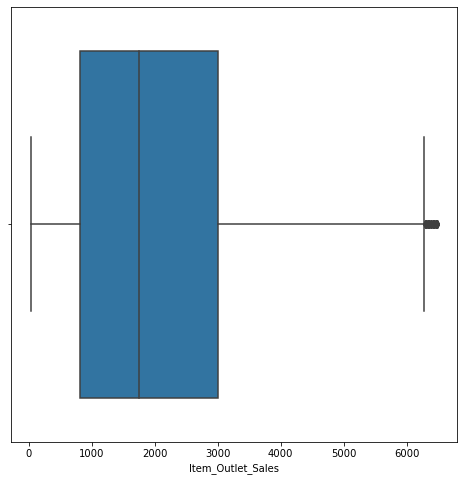

In [21]:
# Quickly checking the result in boxplot

plt.figure(figsize = (8,8))
sns.boxplot(x = 'Item_Outlet_Sales', data = xdf);

#### We will not be fixing skewness in our target attribute as it given incorrect RMSE

In [22]:
## Function for fixing positive skewness
def sqrt_transformation(dataframe):
    return np.sqrt(dataframe)

In [23]:
xdf['Item_Outlet_Sales'] = xdf['Item_Outlet_Sales'].map(sqrt_transformation)

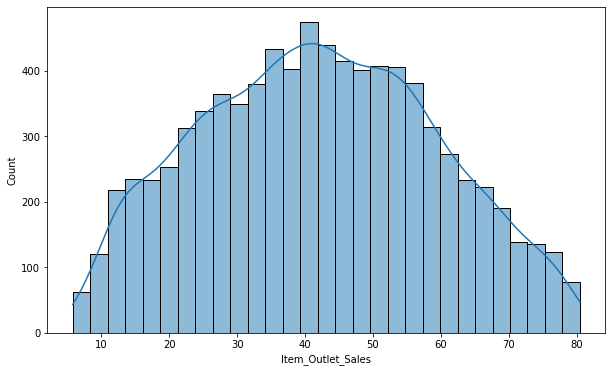

In [24]:
# After fixing skewness

plt.figure(figsize = (10,6))
sns.histplot(data = xdf, x = 'Item_Outlet_Sales', kde = True);

## Univariate Analysis (Independent Variables)

In [25]:
xxdf = xdf.copy()

In [26]:
numerical_df.columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

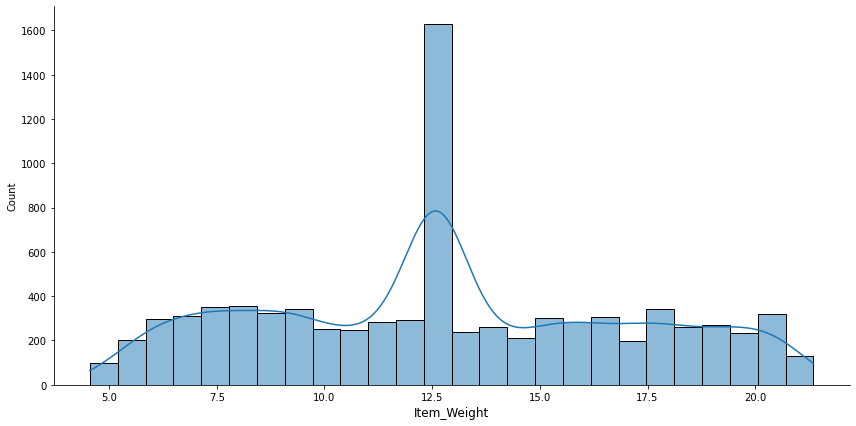

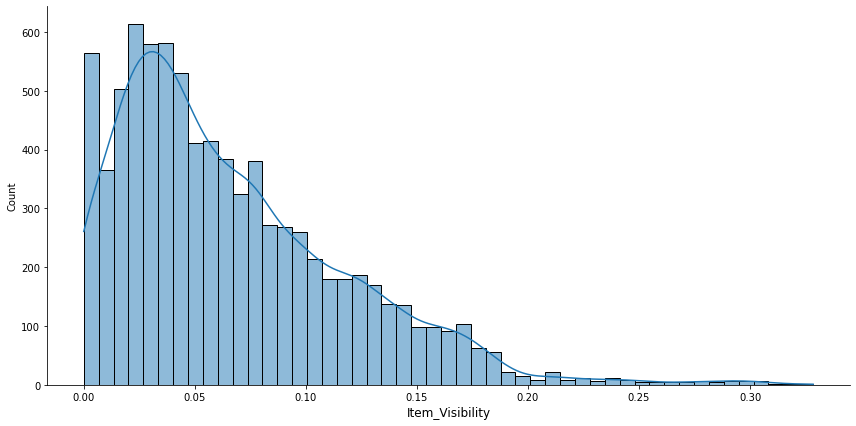

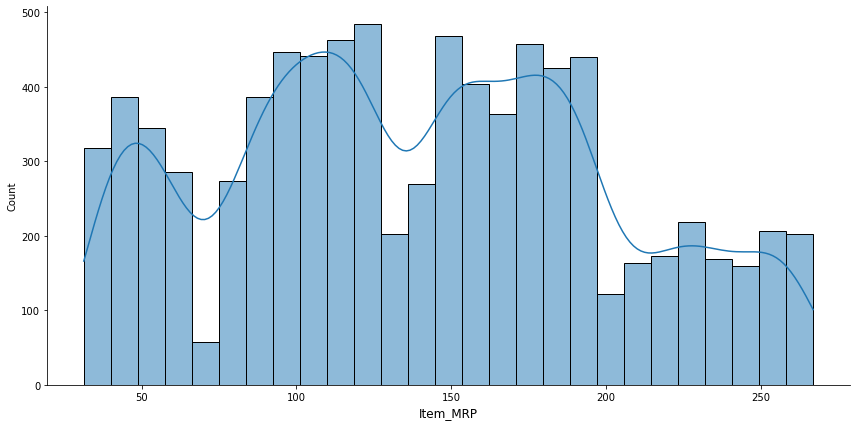

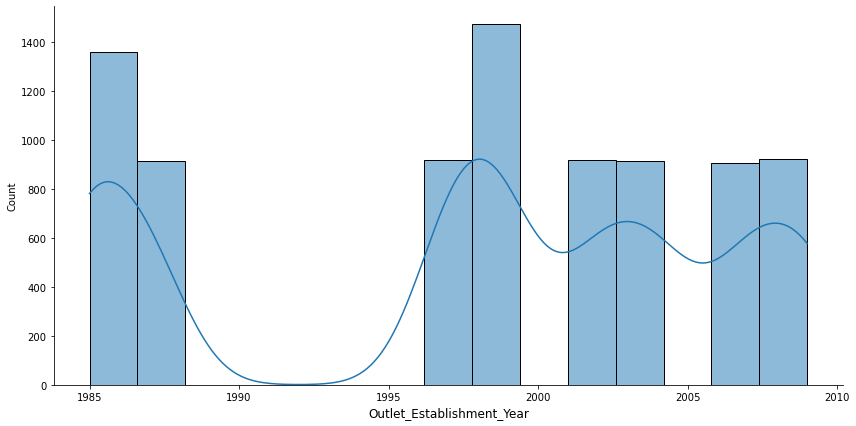

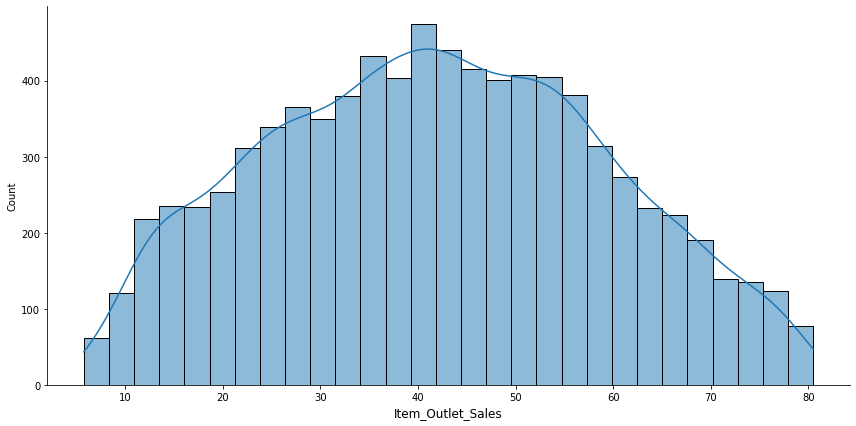

In [27]:
for i in numerical_df:
    sns.displot(data = xxdf, x = i, kde = True, aspect = 2, height = 6);
    plt.xlabel(i, fontsize = 12)

#### Let's take a note, which feature has skewed dataset.

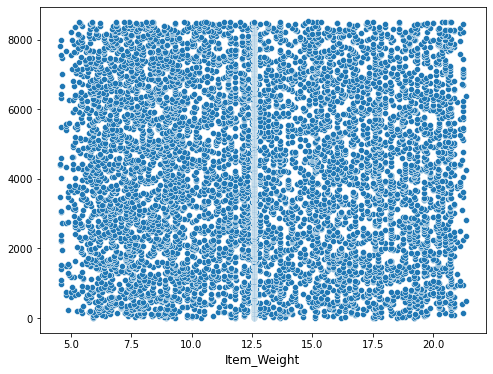

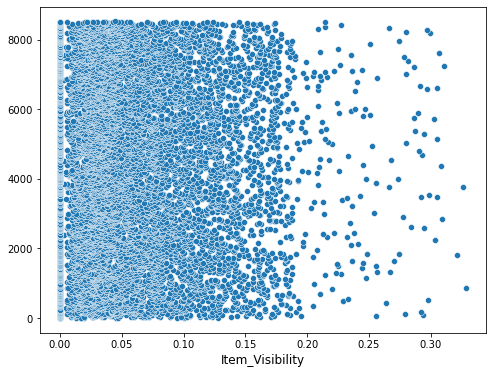

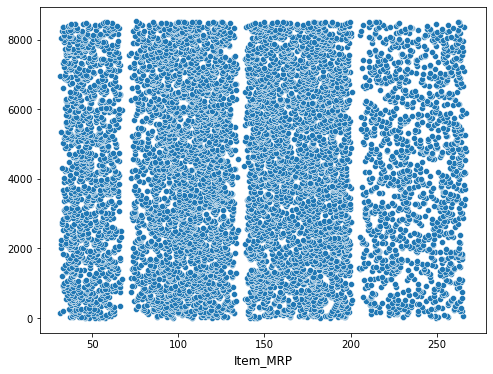

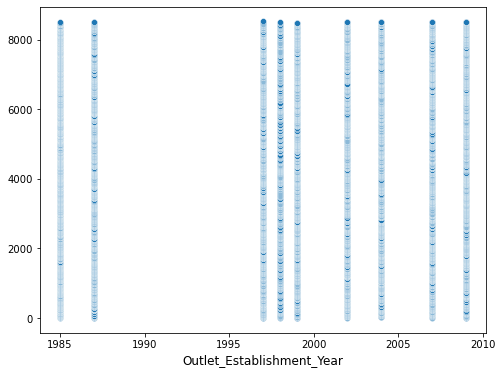

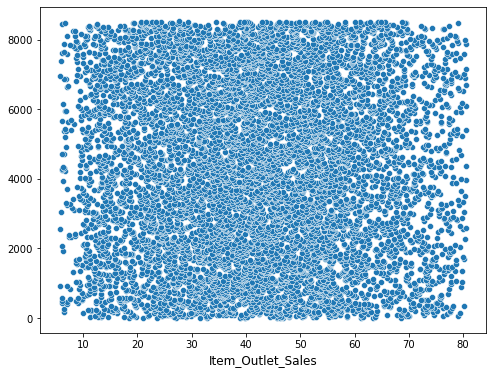

In [28]:
# Checking for outliers

for i in numerical_df:
    plt.figure(figsize =(8,6))
    sns.scatterplot(data = xxdf, y = xdf.index, x = i);
    plt.xlabel(i, fontsize = 12)

#### Also, let's take a note which Attribute contains outliers.

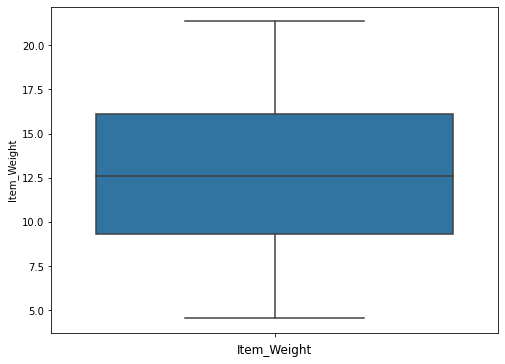

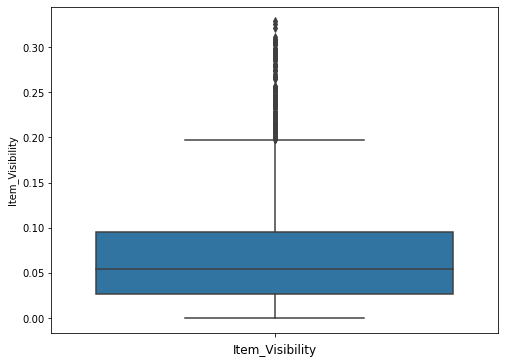

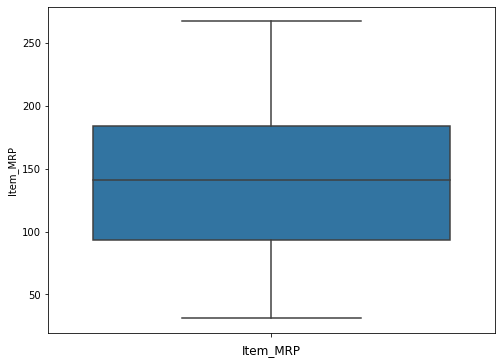

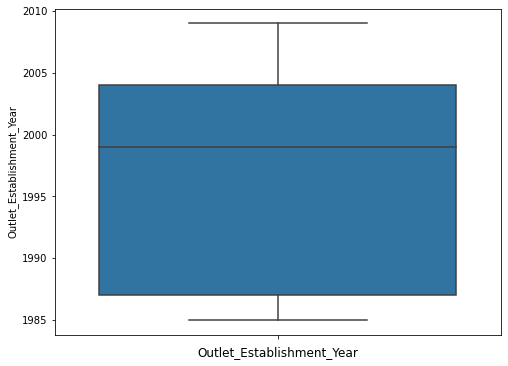

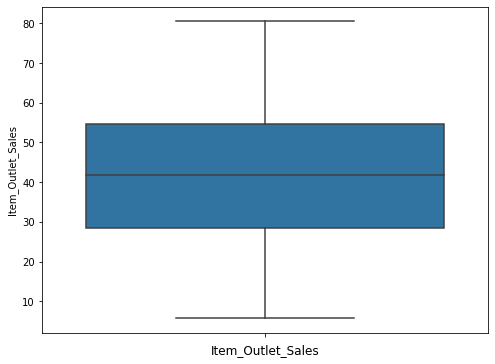

In [29]:
# Confirming the outliers

for i in numerical_df:
    plt.figure(figsize =(8,6))
    sns.boxplot(data = xxdf, y = i);
    plt.xlabel(i, fontsize = 12)

### Observations:

#### Item_Visibility contains outliers, and as well as it is positively skewed on both the dastaset. Let's fix this.

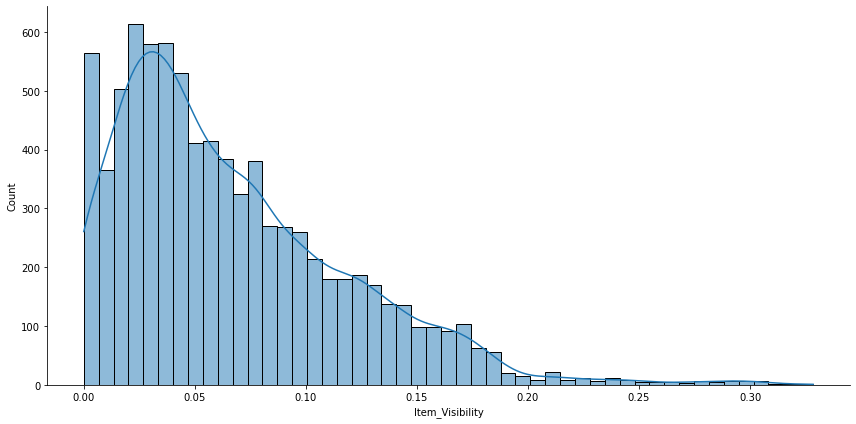

In [30]:
sns.displot(data = xxdf, x = 'Item_Visibility', kde = True, aspect = 2, height = 6);

It contains a 0 value, let's fix that too.

In [31]:
## First Removing strange '0'

xxdf['Item_Visibility'].replace(0, xxdf['Item_Visibility'].median(), inplace = True)

In [32]:
# Treating Postive skewness

xxdf['Item_Visibility'] = xxdf["Item_Visibility"].map(sqrt_transformation)

In [33]:
# Removing Outliers

xxdf = remove_outliers(xxdf, "Item_Visibility")

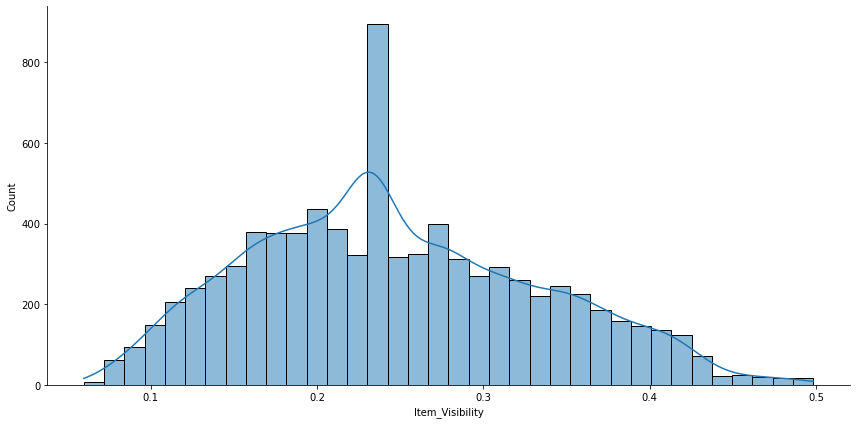

In [34]:
# After remvoing skewness and fixing outliers on trainset

sns.displot(x = 'Item_Visibility', data = xxdf, aspect = 2, height = 6, kde = True);

### Bivariate Analysis

#### First let's see the scatter plot of all the Numerical variables in term of Item_Outlet_Sales

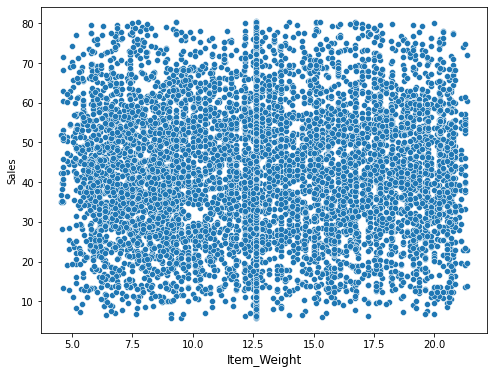

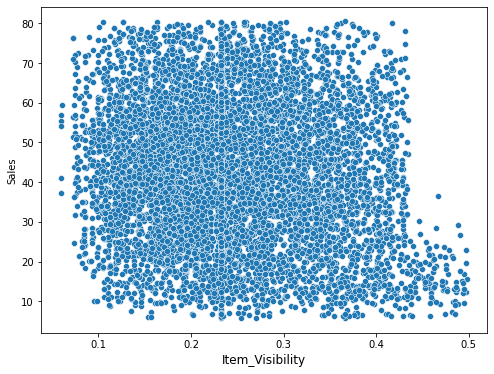

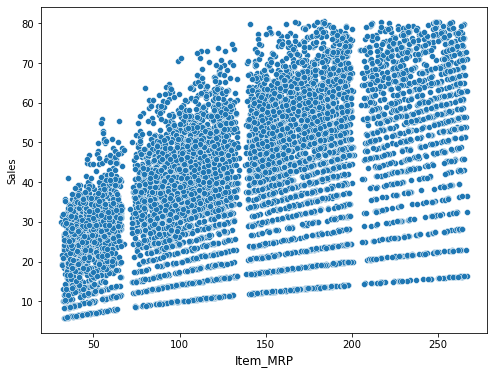

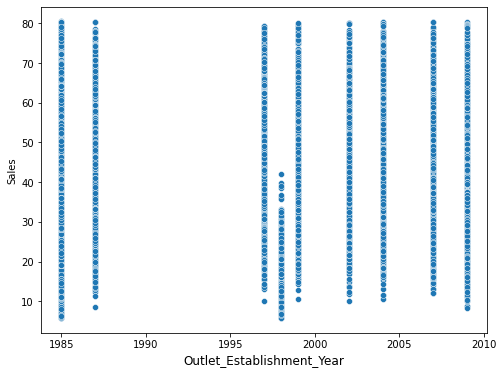

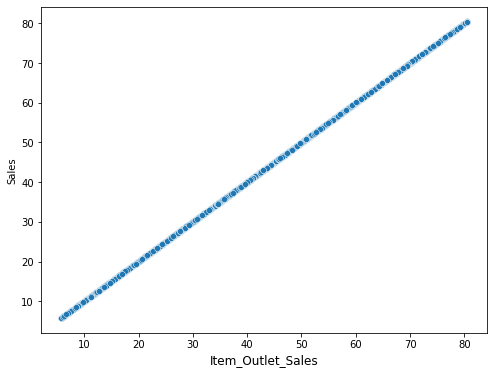

In [35]:
for i in numerical_df:
    plt.figure(figsize =(8,6))
    sns.scatterplot(data = xxdf, x = i, y = xxdf['Item_Outlet_Sales']);
    plt.xlabel(i, fontsize = 12)
    plt.ylabel("Sales")

#### We observe, Item_MRP has linear relationship

In [36]:
bi_df = xxdf.copy()

### Bivariate Analysis (Categorical)

In [37]:
categorical_df.columns

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

#### Countplot

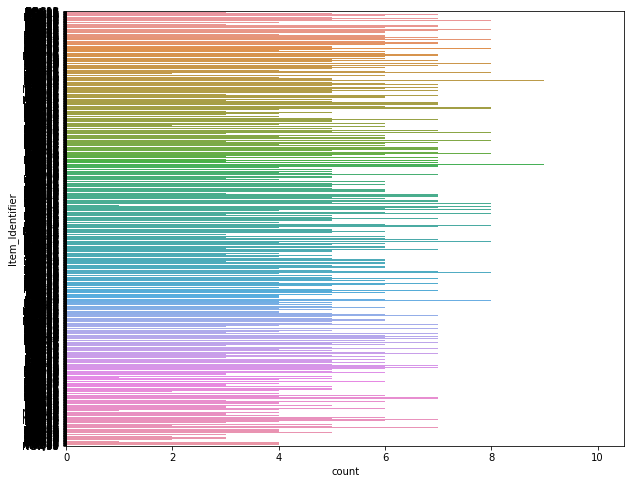

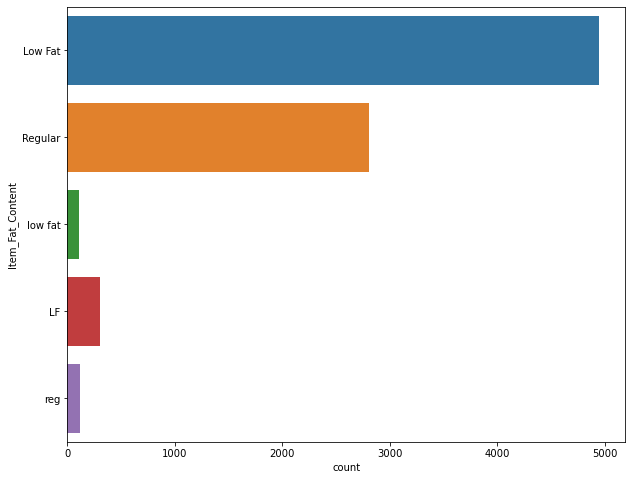

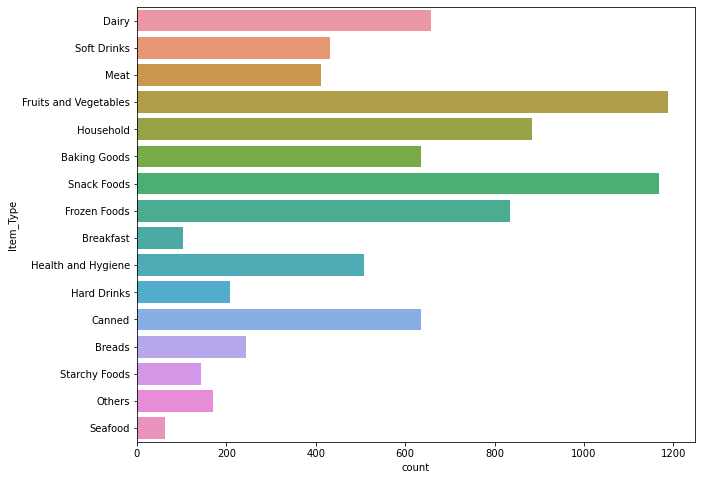

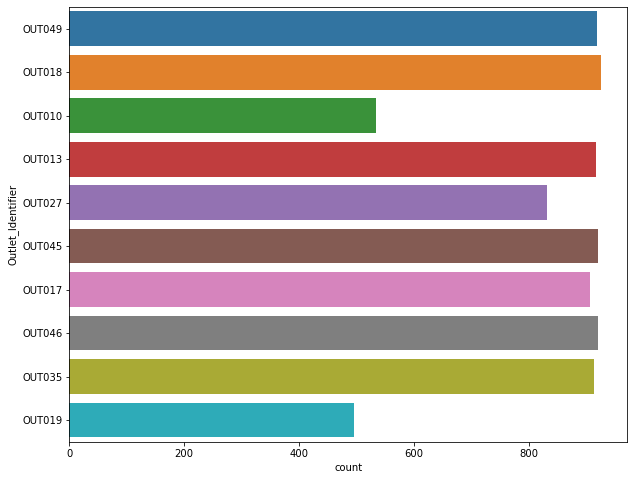

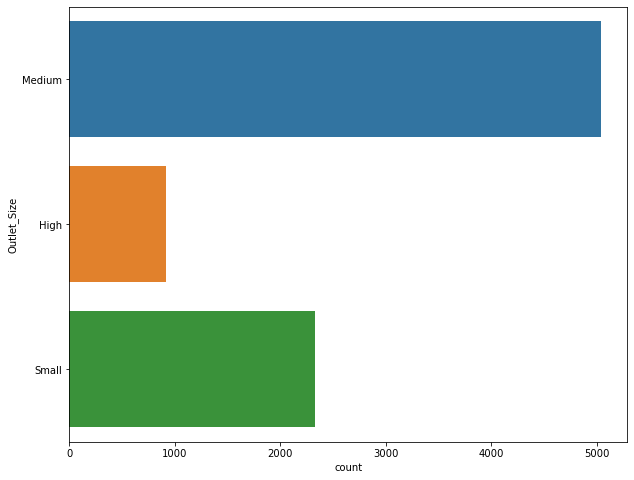

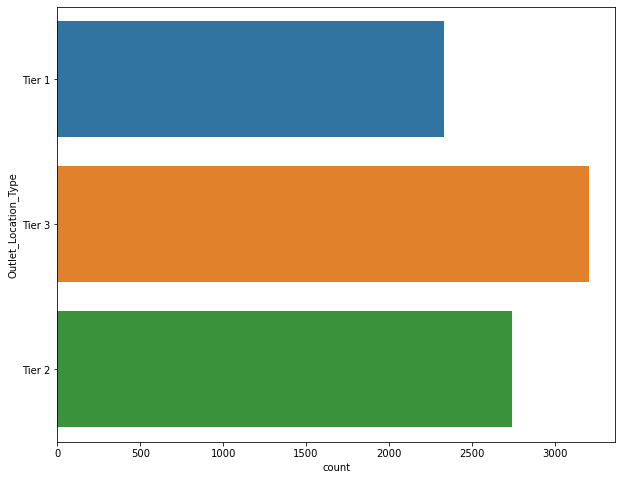

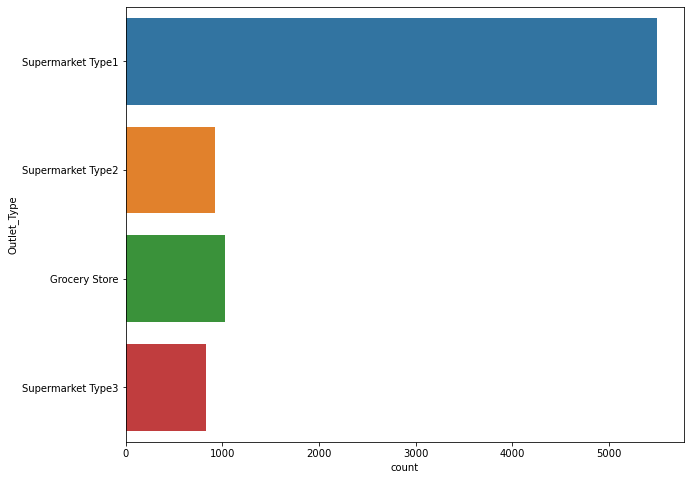

In [38]:
for i in categorical_df:
    plt.figure(figsize = (10,8))
    sns.countplot( y = i, data = bi_df);  

#### Observations:

* Item Identifier: There are lot of individual Item Identifiers.
* Item_Fat_Content: We have multiple same values, let's fix it.
* Fruits & Vegies, Frozen food, Dariy, Household and Snacks has highest number of counts.
* Supermarket has higher number of counts.

#### First let's fix, Item_Fat_Content

In [39]:
bi_df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [40]:
bi_df['Item_Fat_Content'] = bi_df['Item_Fat_Content'].map({"low fat": "Low Fat",
                                                           "Low Fat": "Low Fat",
                                                         "LF":"Low Fat",
                                                         "Regular":"Regular",
                                                         "reg":"Regular"})

In [41]:
bi_df['Item_Fat_Content'].value_counts()

Low Fat    5359
Regular    2923
Name: Item_Fat_Content, dtype: int64

#### In term of Sales?

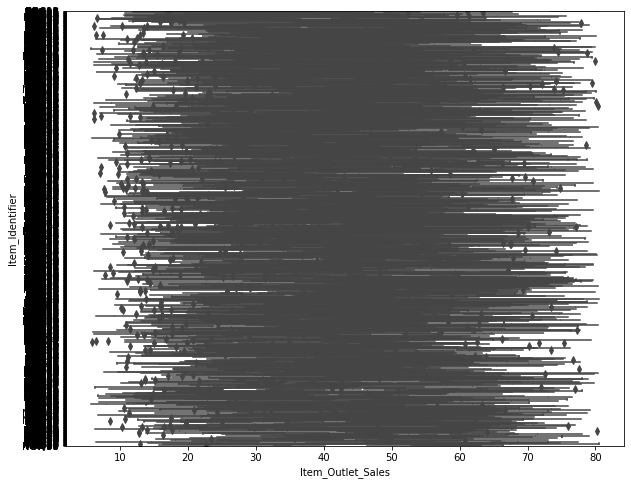

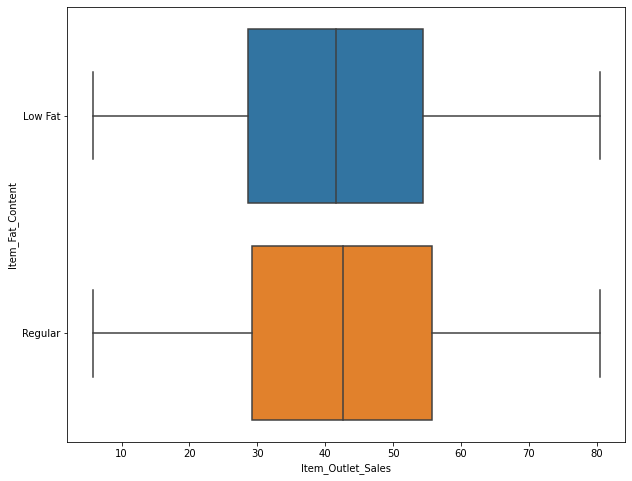

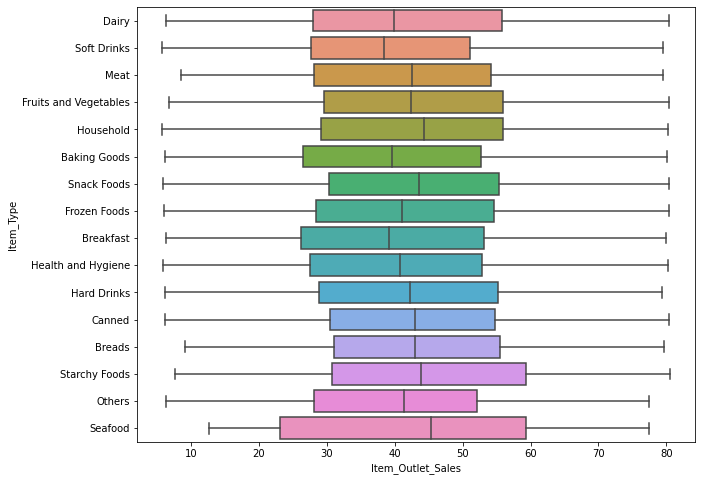

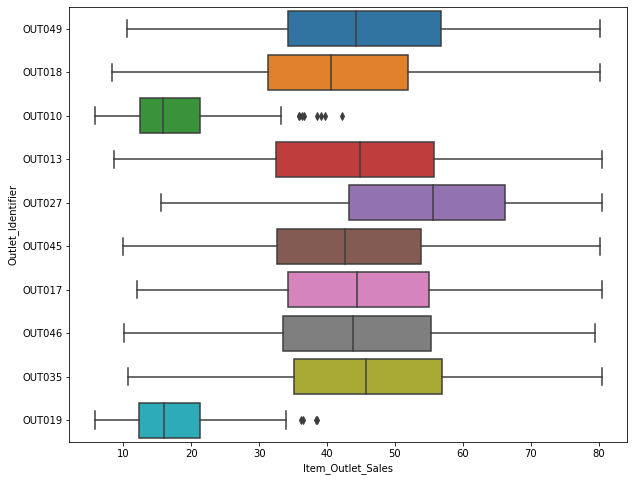

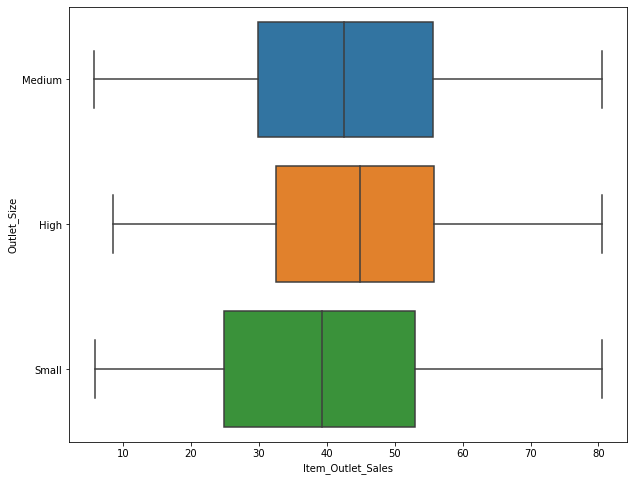

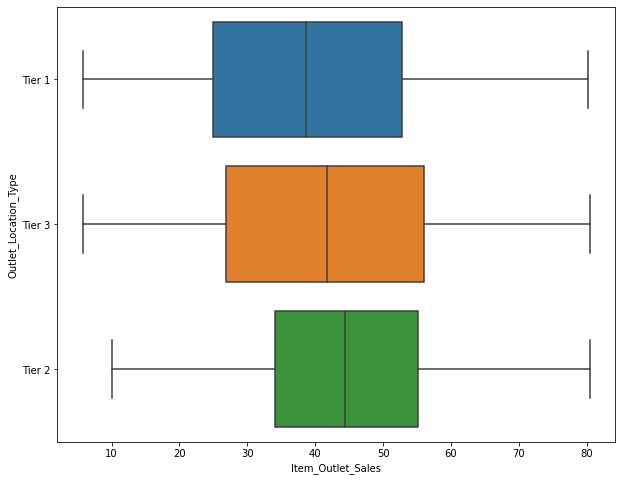

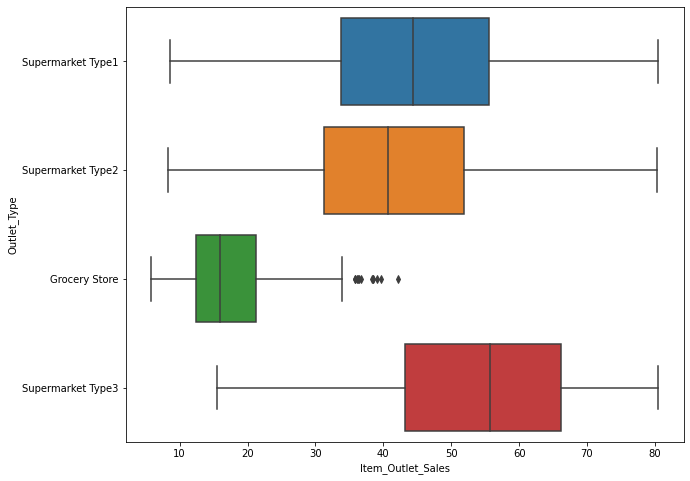

In [42]:
for i in categorical_df:
    plt.figure(figsize = (10,8))
    sns.boxplot( y = i, x = bi_df['Item_Outlet_Sales'],data = bi_df);

#### Observations:

* In terms of 'Outlet_Type', Supermarket has highest demand (Type1 and Type3)
* Starchy Food, Dairy, Fruits & Vegetables and Households has highest sales. But most of them all equal in terms of overall sales.

### Skewness on Numbers

In [43]:
for i in numerical_df:
    print("\n")
    print(i)
    print("-" * 20)
    print("Skewness: %f" % bi_df[i].skew())
    print("Kurtosis: %f" % bi_df[i].kurt())
    print("-" * 20)



Item_Weight
--------------------
Skewness: 0.117195
Kurtosis: -0.889020
--------------------


Item_Visibility
--------------------
Skewness: 0.329221
Kurtosis: -0.513008
--------------------


Item_MRP
--------------------
Skewness: 0.150389
Kurtosis: -0.855955
--------------------


Outlet_Establishment_Year
--------------------
Skewness: -0.427368
Kurtosis: -1.154903
--------------------


Item_Outlet_Sales
--------------------
Skewness: 0.055352
Kurtosis: -0.767968
--------------------


In [44]:
tf_df = bi_df.copy()

### Dataset Transformation

In [45]:
categorical_df.columns

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

### Label Encoding

#### Let's encode all the categorical values, and check the correlation of all the values with 'SalePrice'

In [46]:
from sklearn import preprocessing

In [47]:
label_encoder = preprocessing.LabelEncoder()

In [48]:
categorical_df = tf_df.select_dtypes(include = 'object')

In [49]:
label_df = tf_df.copy()
for i in categorical_df:
    label_df[i] = label_encoder.fit_transform(tf_df[i])

### Correlation

<AxesSubplot:>

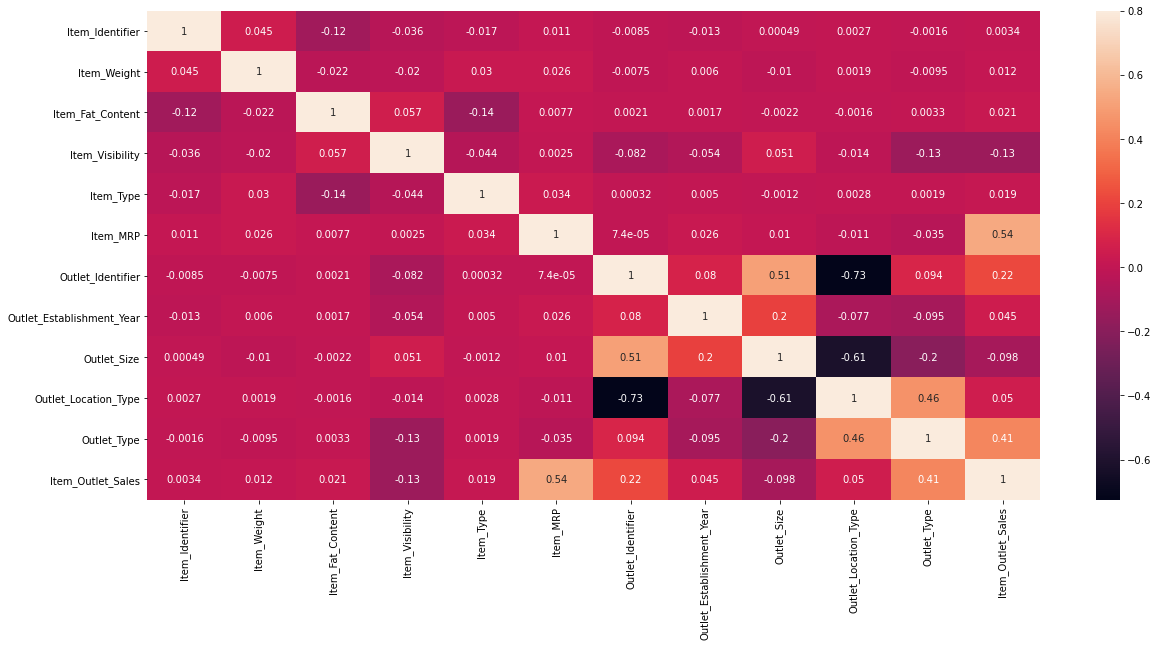

In [50]:
corrmat =label_df.corr()
f, ax = plt.subplots(figsize = (20,9))
sns.heatmap(corrmat, vmax = .8, annot = True)

### Dropping unrelated Columns

In [51]:
drop_columns = ['Item_Visibility','Outlet_Size','Outlet_Establishment_Year','Outlet_Type','Item_Weight','Item_Identifier']

tf_df.drop(drop_columns, axis =1 , inplace = True) 

In [52]:
tf_df

,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Location_Type,Item_Outlet_Sales
0,Low Fat,Dairy,249.8092,OUT049,Tier 1,61.115775
1,Regular,Soft Drinks,48.2692,OUT018,Tier 3,21.057607
2,Low Fat,Meat,141.6180,OUT049,Tier 1,45.795961
3,Regular,Fruits and Vegetables,182.0950,OUT010,Tier 3,27.062520
4,Low Fat,Household,53.8614,OUT013,Tier 3,31.538947
...,...,...,...,...,...,...
8518,Low Fat,Snack Foods,214.5218,OUT013,Tier 3,52.710373
8519,Regular,Baking Goods,108.1570,OUT045,Tier 2,23.436830
8520,Low Fat,Health and Hygiene,85.1224,OUT035,Tier 2,34.541477
8521,Regular,Snack Foods,103.1332,OUT018,Tier 3,42.960419


### One Hot Encoding

In [53]:
tf_df = pd.get_dummies(tf_df)

In [54]:
tf_df

,Item_MRP,Item_Outlet_Sales,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3
0,249.8092,61.115775,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
1,48.2692,21.057607,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,141.6180,45.795961,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,182.0950,27.062520,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,53.8614,31.538947,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,214.5218,52.710373,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8519,108.1570,23.436830,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
8520,85.1224,34.541477,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
8521,103.1332,42.960419,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


### Preparing the Dataset

In [55]:
X = tf_df.drop(['Item_Outlet_Sales'], axis = 1)
y = tf_df['Item_Outlet_Sales']

### Scaling the Dataset

In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X1 = scaler.fit_transform(X)
X = pd.DataFrame(data = X1, columns = X.columns)

In [57]:
X.head()

,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,...,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3
0,1.796967,0.738537,-0.738537,-0.288165,-0.173861,-0.111667,-0.288165,3.406726,-0.334852,-0.409426,...,-0.354585,-0.252126,-0.334182,-0.352207,-0.353505,-0.353505,2.830542,1.596376,-0.703332,-0.794935
1,-1.476382,-1.354027,1.354027,-0.288165,-0.173861,-0.111667,-0.288165,-0.293537,-0.334852,-0.409426,...,2.820197,-0.252126,-0.334182,-0.352207,-0.353505,-0.353505,-0.353289,-0.626419,-0.703332,1.257965
2,0.039760,0.738537,-0.738537,-0.288165,-0.173861,-0.111667,-0.288165,-0.293537,-0.334852,-0.409426,...,-0.354585,-0.252126,-0.334182,-0.352207,-0.353505,-0.353505,2.830542,1.596376,-0.703332,-0.794935
3,0.697175,-1.354027,1.354027,-0.288165,-0.173861,-0.111667,-0.288165,-0.293537,-0.334852,2.442441,...,-0.354585,-0.252126,-0.334182,-0.352207,-0.353505,-0.353505,-0.353289,-0.626419,-0.703332,1.257965
4,-1.385555,0.738537,-0.738537,-0.288165,-0.173861,-0.111667,-0.288165,-0.293537,-0.334852,-0.409426,...,-0.354585,-0.252126,-0.334182,-0.352207,-0.353505,-0.353505,-0.353289,-0.626419,-0.703332,1.257965


### Splitting Dataset

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6625, 32), (1657, 32), (6625,), (1657,))

### Modeling and Evaluation Metrics

#### Linear Regression

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score
import math

In [60]:
lr = LinearRegression(normalize = True)
lr.fit(X_train, y_train)

LinearRegression(normalize=True)

In [61]:
lr_predict = lr.predict(X_test)

In [67]:
yp = lr.predict(X_test)
print("R2 Score:", r2_score(y_test, lr_predict))
print("Mean Squarred Error:", mean_squared_error(y_test, lr_predict))
print("RMSE:", math.sqrt(mean_squared_error(y_test, lr_predict)))
print("Mean Absolute Error : " + str(mean_absolute_error(y_test,lr_predict)))

R2 Score: 0.6258463644490504
Mean Squarred Error: 109.09223825352484
RMSE: 10.444722985964004
Mean Absolute Error : 8.22234114454839


### XGBOOST REGRESSOR

In [68]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators = 1000, learning_rate = 0.05)
xgb.fit(X_train, y_train)

predict = xgb.predict(X_test)

C:\Users\jameel\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [71]:
print("R2 Score:", r2_score(y_test, predict))
print("Mean Squarred Error:", mean_squared_error(y_test, predict))
print("RMSE:", math.sqrt(mean_squared_error(y_test, predict)))
print("Mean Absolute Error : " + str(mean_absolute_error(y_test,predict)))

R2 Score: 0.6081413481704621
Mean Squarred Error: 114.25450228258376
RMSE: 10.688989769037285
Mean Absolute Error : 8.170752139281827


### LASSO REGRSSOR

In [72]:
from sklearn.linear_model import Lasso

In [73]:
ls = Lasso(alpha = 0.01)
ls.fit(X_train, y_train)

Lasso(alpha=0.01)

In [74]:
lasso_pred = ls.predict(X_test)

In [75]:
print("R2 Score:", r2_score(y_test, lasso_pred))
print("Mean Squarred Error:", mean_squared_error(y_test, lasso_pred))
print("RMSE:", math.sqrt(mean_squared_error(y_test, lasso_pred)))
print("Mean Absolute Error : " + str(mean_absolute_error(y_test,lasso_pred)))

R2 Score: 0.6259601452807628
Mean Squarred Error: 109.05906309652396
RMSE: 10.443134735151316
Mean Absolute Error : 8.219198262721386


In [77]:
# installing lightgbm
# pip install lightgbm requests pandas

### LGBMRegressor

In [78]:
from lightgbm import LGBMRegressor

In [79]:
lgbm = LGBMRegressor()

In [80]:
lgbm.fit(X_train, y_train)

LGBMRegressor()

In [81]:
lgbm_pred = lgbm.predict(X_test)

In [82]:
print("R2 Score:", r2_score(y_test, lgbm_pred))
print("Mean Squarred Error:", mean_squared_error(y_test, lgbm_pred))
print("RMSE:", math.sqrt(mean_squared_error(y_test, lgbm_pred)))
print("Mean Absolute Error : " + str(mean_absolute_error(y_test,lgbm_pred)))

R2 Score: 0.6383353218326207
Mean Squarred Error: 105.4508241792761
RMSE: 10.268925171568643
Mean Absolute Error : 7.829078684977118


### RandomForestRegressor

In [83]:
from sklearn.ensemble import RandomForestRegressor

In [84]:
rf = RandomForestRegressor(n_estimators = 50, max_depth = 15, random_state = 47, min_samples_leaf = 10)

In [85]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=10, n_estimators=50,
                      random_state=47)

In [86]:
rf_pred = rf.predict(X_test)

In [87]:
print("R2 Score:", r2_score(y_test, rf_pred))
print("Mean Squarred Error:", mean_squared_error(y_test, rf_pred))
print("RMSE:", math.sqrt(mean_squared_error(y_test, rf_pred)))
print("Mean Absolute Error : " + str(mean_absolute_error(y_test,rf_pred)))

R2 Score: 0.6417413239907617
Mean Squarred Error: 104.45773373828438
RMSE: 10.22045663061511
Mean Absolute Error : 7.8089811909268585


### DecisionTreeRegressor

In [88]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [89]:
dt = DecisionTreeRegressor()

param_dist = {
            'max_depth': [2,5,10,50,25,30,40,],
}

dt_gs = GridSearchCV(dt, param_grid = param_dist, cv = 6)
dt_gs.fit(X_train, y_train)

dt_predict = dt_gs.predict(X_test)

In [90]:
print("R2 Score:", r2_score(y_test, dt_predict))
print("Mean Squarred Error:", mean_squared_error(y_test, dt_predict))
print("RMSE:", math.sqrt(mean_squared_error(y_test, dt_predict)))
print("Mean Absolute Error : " + str(mean_absolute_error(y_test,dt_predict)))

R2 Score: 0.6345764081156513
Mean Squarred Error: 106.5468132912948
RMSE: 10.322151582460645
Mean Absolute Error : 7.946544118712797


# Model Saving

In [91]:
# saving random forest regressor
import pickle
filename = 'Big_Data_Mart.pkl'
pickle.dump(rf, open(filename, 'wb'))

# Conclusion:

In [92]:
import numpy as np
a= np.array(y_test)
predicted=np.array(rf.predict(X_test))
df_conc=pd.DataFrame({"Original":a, "Predicted":predicted}, index= range(len(a)))
df_conc

,Original,Predicted
0,24.923712,23.730795
1,29.869248,36.504453
2,45.284258,59.618132
3,70.527950,59.639336
4,58.981395,55.687061
...,...,...
1652,60.243471,51.166368
1653,12.875721,12.070831
1654,23.006760,35.363359
1655,17.154696,18.112219
